## Energy Consumption Prediction Model

This project is to create a machine learning model to predict energy consumption usage.

I am training the model using power usage data obtained from a Tesla Powerwall. Data points are at 5 mins interval. I am using Long Short Team Model (LSTM) as this seems to be best model for time-series data prediction.

In [1]:
# Code Imports

!pip install -r ../requirements.txt

import os     # miscellaneous os interfaces
import sys    # configuring python runtime environment
import datetime as dt
import time   # library for time manipulation, and logging
from pathlib import Path
import pickle # load/save model as a pickle file

import pandas as pd  # data manipulation and analysis
import numpy as np   # numerical operations
import torch         # pytorch library for tensor operations
import lightning as L

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

### Data Analysis Setup


In [249]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%precision 5
%matplotlib inline
sns.set_style('whitegrid');

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 17) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.5f}'.format # float precisions

torch.manual_seed(42)

## Global Argument(s)

The global arguments are _notebook_ specific, however they may also be extended to external libraries and functions on import. The _boilerplate_ provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.


In [250]:
ROOT = ".."  # the document root is one level up, that contains all code structure
DATA = Path(ROOT) / "data"  # the directory contains all data files
RAW_DATA = DATA / "raw"

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = DATA / "processed"

## Data Preparation

Under the `data` directory, there are 2 scrpts:

`fetch_powerwall_data.py` - Fetch history data from Tesla's API. This requires Tesla API access token. This script fetches the time series data. One file a day. Each file is the raw response from the API.

`extract_powerwall_data.py` - This processes all the raw response data and merge them all into a single time series data file. This output file is the one that we use for further data preparation and training.

In [251]:
from typing import Any, Dict, List
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
import pickle

def to_seconds(time_obj):
    """
    Convert a time of day object into a number representing the number of seconds since the start of the day.
    
    Args:
        time_obj (datetime.time): Time of day object.
    
    Returns:
        float: Number of seconds since the start of the day.
    """
    return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second)

class PowerwallDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_file: str,
        feature_columns: List[str],
        sequence_length: int,
        batch_size: int,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.data_file = data_file
        self.feature_columns = feature_columns
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.standard_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler(feature_range=(0, 1))

        # Load and preprocess data
        self.column_transformer = ColumnTransformer(
            transformers=[
                ("standard", self.standard_scaler, ["total_home_usage"]),
                (
                    "minmax",
                    self.minmax_scaler,
                    [col for col in feature_columns if col != "total_home_usage"],
                ),
            ]
        )
        self.column_transformer.set_output(transform="pandas")
        self.data = None

    # Create sequences for LSTM
    def create_sequences(self, dataframe: pd.DataFrame, sequence_length):
        dataset = dataframe.values

        features = []
        targets = []
        for i in range(len(dataset) - sequence_length):
            features.append(dataset[i : i + sequence_length])
            targets.append(dataset[i + sequence_length][-1])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            targets, dtype=torch.float32
        )  # features, targets

    def prepare_data(self):
        # Load and preprocess data
        df = pd.read_csv(PROCESSED_DATA / "time_series_data.csv", parse_dates=True)

        # Convert the "timestamp" column to datetime type
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert(
            "Australia/Sydney"
        )
        df["time_of_day"] = df["timestamp"].dt.time.apply(to_seconds)
        df["day_of_week"] = df["timestamp"].dt.day_of_week
        df["year"] = df["timestamp"].dt.year
        df["month"] = df["timestamp"].dt.month
        df["day"] = df["timestamp"].dt.day
        df["total_home_usage"] = df["total_home_usage"].interpolate(method="linear")
        df["total_battery_charge"] = df["total_battery_charge"].interpolate(
            method="linear"
        )
        df["total_battery_discharge"] = df["total_battery_discharge"].interpolate(
            method="linear"
        )
        df["total_grid_energy_exported"] = df["total_grid_energy_exported"].interpolate(
            method="linear"
        )
        df["total_battery_charge"] = df["total_battery_charge"].interpolate(
            method="linear"
        )
        df["total_solar_generation"] = df["total_solar_generation"].interpolate(
            method="linear"
        )
        df.drop(
            columns=[
                "total_battery_charge",
                "total_battery_charge",
                "total_grid_energy_exported",
            ],
            inplace=True,
        )
        assert (df.isnull().sum() == 0).all(), "Validate no missing values"

        data_to_resample = df[["timestamp", "total_home_usage"]]
        data_half_hourly = (
            data_to_resample.resample("5min", on="timestamp").sum().reset_index()
        )
        data_half_hourly["timestamp"] = pd.to_datetime(
            data_half_hourly["timestamp"], utc=True
        ).dt.tz_convert("Australia/Sydney")
        data_half_hourly["time_of_day"] = data_half_hourly["timestamp"].dt.time.apply(
            to_seconds
        )
        data_half_hourly["day_of_week"] = data_half_hourly["timestamp"].dt.day_of_week
        data_half_hourly["year"] = data_half_hourly["timestamp"].dt.year
        data_half_hourly["month"] = data_half_hourly["timestamp"].dt.month
        data_half_hourly["day"] = data_half_hourly["timestamp"].dt.day
        self.data = data_half_hourly
        self.last_sequence_data = self.data[-self.sequence_length :][
            "total_home_usage"
        ].tolist()

        # When using a column transformer, the column order is not preserved. To preseve the column order,
        # we set the out to be a dataframe so we can "fix" the order before returning it as an array.
        # See https://stackoverflow.com/a/77702955
        normalized_data = self.column_transformer.fit_transform(
            self.data[self.data["year"] == 2024][self.feature_columns]
        )
        normalized_data = normalized_data.rename(columns=lambda x: x.split("__", 1)[-1])
        normalized_data = normalized_data[self.feature_columns]

        # Create sequences for training
        features, targets = self.create_sequences(normalized_data, self.sequence_length)
        # features = features.to(device)
        # targets = targets.to(device)

        # Split data into training and validation sets
        train_size = int(0.8 * len(normalized_data))
        print(
            f"train_size: {train_size} valid_size: {len(normalized_data) - train_size}"
        )
        train_ds = TensorDataset(features[:train_size], targets[:train_size])
        valid_ds = TensorDataset(features[train_size:], targets[train_size:])

        self.trainloader = DataLoader(
            train_ds, batch_size=self.batch_size, num_workers=4, shuffle=True
        )
        self.validloader = DataLoader(
            valid_ds, batch_size=self.batch_size, num_workers=4, shuffle=False
        )

    def train_dataloader(self):
        return self.trainloader

    def val_dataloader(self):
        return self.validloader

    def target_scaler(self):
        return self.column_transformer.named_transformers_["standard"]

    def state_dict(self) -> Dict[str, Any]:
        # Create a custom state dict that includes both model parameters and the transformer
        state_dict = super().state_dict()

        # Save the fitted column transformer. It will be used for inference.
        column_transformer_data = pickle.dumps(self.column_transformer)
        state_dict["column_transformer"] = column_transformer_data

        # Save the last {sequence_length} rows of the data
        state_dict["last_sequence_data"] = self.last_sequence_data

        return state_dict

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        # Load the transformer from the state dict
        column_transformer_data = state_dict.pop("column_transformer", None)
        if column_transformer_data:
            self.column_transformer = pickle.loads(column_transformer_data)

        self.last_sequence_data = state_dict.pop("last_sequence_data", None)

        return super().load_state_dict(state_dict)

## The Model

This uses PyTorch's LSTM model. MSE (Mean Square Error) as the loss function. Adam optimizer.

I think they are the typical setup.

In [252]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightning as L


from torch.optim import Adam
import torch.utils
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.utils.data


class LSTMModel(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.save_hyperparameters()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        xb, yb = batch
        preds = self(xb)
        loss = nn.MSELoss()(preds[:, 0], yb)
        self.log("train_loss", loss)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        xb, yb = batch
        preds = self(xb)
        loss = nn.MSELoss()(preds[:, 0], yb)
        self.log("val_loss", loss)
        return {"val_loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Training

Here is the configuration and hyperparameters for the model and training.

In [253]:
from lightning.pytorch.callbacks import ModelCheckpoint

FEATURE_COLUMNS = [
    # "year",
    "month",
    # "day",
    "day_of_week",
    "time_of_day",
    # "temperature",
    # "humidity",
    # "wind_speed",
    # "precipitation",
    # "cloud_cover",
    # "weather_description",
    "total_home_usage",
    # "grid_energy_export",
]
TARGET_COLUMN = ["total_home_usage"]
TIME_RESOLUTION = 5  # minutes
SEQUENCE_LENGTH = 24 * (60 // TIME_RESOLUTION)  # Sequence length - 24 hours data
BATCH_SIZE = 300
FEATURE_COLUMNS = [
    # "year",
    "month",
    # "day",
    "day_of_week",
    "time_of_day",
    # "temperature",
    # "humidity",
    # "wind_speed",
    # "precipitation",
    # "cloud_cover",
    # "weather_description",
    "total_home_usage",
    # "grid_energy_export",
]
use_last_num_data_points = -1  # 24 * 2 * 30 * 15  # 12 months of data

data_module = PowerwallDataModule(
    data_file=PROCESSED_DATA / "time_series_data.csv",
    feature_columns=FEATURE_COLUMNS,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
)


# Hyperparameters
input_size = len(FEATURE_COLUMNS)
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Predicting one value (Energy consumption)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

num_epochs = 30  # Number of training epochs

# Set up the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="model_checkpoints",  # Directory where checkpoints are saved
    filename="power_consumption_model-{epoch:02d}-{val_loss:.2f}",  # Custom file name
    save_top_k=3,  # Save the top 3 models
    monitor="val_loss",  # Monitor the validation loss to determine the best model
    mode="min",  # Save models with the minimum validation loss
)
trainer = L.Trainer(
    max_epochs=num_epochs,
    accumulate_grad_batches=4,
    log_every_n_steps=20,
    accelerator="mps",
    callbacks=[checkpoint_callback],
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [254]:
trainer.fit(model, data_module)

# Loaded data
data = data_module.data

/Users/eho/dev/energy-consumption-prediction/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/eho/dev/energy-consumption-prediction/experiments/model_checkpoints exists and is not empty.

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 200 K  | train
1 | fc   | Linear | 129    | train
----------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.803     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


train_size: 63139 valid_size: 15785


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/eho/dev/energy-consumption-prediction/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/eho/dev/energy-consumption-prediction/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


I ran for 30 epochs. Lightning saved the checkpoints with the best validation loss along the way.

## Prediction


The prediction function takes in a start date when you want the prediction from and how many steps you want to predict for.

The prediction function requires the `column_transformer` (the scaler fitted from training data) which is used for scaling new data.

The prediction function also requires the last sequence of the training data. This is used for the next step prediction. I am not sure if this is really necessary. I could probably initialise the input sequence with 0 and see what the model predicts.

In [255]:
import torch
import pandas as pd
from datetime import timedelta, datetime, date


class Prediction:
    def __init__(
        self,
        model: LSTMModel,
        last_sequence_data: List[float],
        sequence_length: int,
        feature_columns: List[str],
        column_transformer: ColumnTransformer,
    ):
        self.model = model
        self.last_sequence_data = last_sequence_data
        self.sequence_length = sequence_length
        self.feature_columns = feature_columns
        self.column_transformer = column_transformer
        self.target_scaler = column_transformer.named_transformers_["standard"]
        assert len(self.last_sequence_data) == self.sequence_length

    def generate_time_steps(self, start_datetime: datetime, num_steps: int):
        """
        Generates the last `num_steps` time steps from the given datetime.
        We use last_sequence_data as as template for "existing value". We will juse use it to predict the next value.
        We need to modify the month, time_of_day, and day_of_week to match the start_date.

        Args:
            start_datetime (datetime): The reference datetime.
            num_steps (int): Number of time steps to generate (default is 24).

        Returns:
            pd.DataFrame: DataFrame containing the month, time_of_day (seconds from start of the day),
                        day_of_week (0-6), and consumption (set to 0).
        """
        time_steps = []

        for i in range(num_steps):
            step_datetime = start_datetime - timedelta(minutes=i * TIME_RESOLUTION)
            month = step_datetime.month
            time_of_day = (
                step_datetime.hour * 3600
                + step_datetime.minute * 60
                + step_datetime.second
            )  # seconds from start of day
            day_of_week = step_datetime.weekday()  # Monday is 0, Sunday is 6

            time_steps.append(
                {
                    "timestamp": step_datetime,
                    "month": month,
                    "time_of_day": time_of_day,
                    "day_of_week": day_of_week,
                    "total_home_usage": self.last_sequence_data[i],
                }
            )

        # Reverse the order of the list since we generate the past timesteps from the reference datetime
        time_steps.reverse()

        return pd.DataFrame(time_steps)

    def predict(self, start_date: date, predict_steps: int = 10):
        # Initialize the result list
        result = []
        start_datetime = datetime.combine(start_date, datetime.min.time())

        # Generate the initial input data (past {sequence_length} time steps)
        input_data_df = self.generate_time_steps(start_datetime, self.sequence_length)

        # Transform/scale the input features
        input_features = self.column_transformer.transform(
            input_data_df[self.feature_columns]
        )
        input_features = input_features.rename(columns=lambda x: x.split("__", 1)[-1])

        # This makes sure the columns are in the right order.
        input_features = input_features[self.feature_columns]

        # Convert the input features to a tensor with shape (1, sequence_length, len(feature_columns))
        input_tensor = torch.tensor(
            input_features.values, dtype=torch.float32, device=self.model.device
        ).unsqueeze(0)
        assert input_tensor.shape == (
            1,
            self.sequence_length,
            len(self.feature_columns),
        )

        self.model.eval()

        # Predict for the next `predict_steps` time steps
        for i in range(predict_steps):
            # Make a prediction
            with torch.no_grad():
                prediction_from_model = self.model(input_tensor)
                transformed_prediction = self.target_scaler.inverse_transform(
                    prediction_from_model.cpu()
                )

                # Extract the predicted consumption value
                predicted_consumption = transformed_prediction[0, -1]

            # Get the next timestamp
            next_datetime = start_datetime + timedelta(minutes=TIME_RESOLUTION * (i + 1))

            # Get the month, time_of_day, and day_of_week for the next timestep
            month = next_datetime.month
            time_of_day = (
                next_datetime.hour * 3600
                + next_datetime.minute * 60
                + next_datetime.second
            )
            day_of_week = next_datetime.weekday()

            # Store the result
            result.append(
                {
                    "timestamp": next_datetime,
                    "month": month,
                    "day_of_week": day_of_week,
                    "time_of_day": time_of_day,
                    "total_home_usage": predicted_consumption,
                }
            )

            # Update input_tensor for the next prediction by appending new feature data
            next_input_features = self.column_transformer.transform(
                pd.DataFrame([result[-1]])
            )
            next_input_features = next_input_features.rename(
                columns=lambda x: x.split("__", 1)[-1]
            )
            next_input_features = next_input_features[self.feature_columns]
            input_tensor = torch.cat(
                (
                    input_tensor[:, 1:, :],
                    torch.tensor(
                        next_input_features.values,
                        dtype=torch.float32,
                        device=self.model.device,
                    ).unsqueeze(0),
                ),
                dim=1,
            )

        # Convert the result into a DataFrame
        result_df = pd.DataFrame(result)

        return result_df

This loads the previously saved model and datamodule. They contain the previously trained weights and biases. The saved data module contains the fitted column scalers. We use the scalers that were previously fitted with training data and use that to normalise future data.


In [256]:
print(f"Loading best model from {checkpoint_callback.best_model_path}")

saved_model = LSTMModel.load_from_checkpoint(checkpoint_callback.best_model_path)
saved_data_module = PowerwallDataModule.load_from_checkpoint(
    checkpoint_callback.best_model_path
)
prediction = Prediction(
    saved_model,
    saved_data_module.last_sequence_data,
    saved_data_module.sequence_length,
    saved_data_module.feature_columns,
    saved_data_module.column_transformer,
)

new_data = prediction.predict(date(2024, 10, 1), predict_steps=SEQUENCE_LENGTH * 30)

Loading best model from /Users/eho/dev/energy-consumption-prediction/experiments/model_checkpoints/power_consumption_model-epoch=23-val_loss=0.17.ckpt


## Visualization


In [259]:
%matplotlib inline
from ipywidgets import interact
import matplotlib.cm as cm

sns.set_theme()
#sns.set_context("notebook")

def scale_hour_to_seconds(hour: int):
    return hour * 60 * 60

def plot_consumption(data: pd.DataFrame, year: int, title_suffix: str = None):
    def month_titles_for_year(year):
        return {
            1: f"Jan {year}",
            2: f"Feb {year}",
            3: f"Mar {year}",
            4: f"Apr {year}",
            5: f"May {year}",
            6: f"Jun {year}",
            7: f"Jul {year}",
            8: f"Aug {year}",
            9: f"Sep {year}",
            10: f"Oct {year}",
            11: f"Nov {year}",
            12: f"Dec {year}"
        }
    month_titles = month_titles_for_year(year)

    g = sns.relplot(
        data=data,
        kind="line",
        x="time_of_day",
        y="total_home_usage",
        hue="day_of_week",
        col="month",
        col_wrap=4,
        facet_kws={"palette": ["red"]}
    )

    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelbottom=True)  # Thi show x-axis labels on the bottom for all subplots
        ax.set_ylabel("Total Home Usage (kWh)", labelpad=10, fontsize=14)  # set y-axis label font size
        ax.set_xlabel("Time of Day", labelpad=15, fontsize=14)  # set x-axis label font size

        # Set x-axis tick label font size and rotation
        ax.tick_params(axis='x', labelsize=12)

        # Set x-axis and x-axis limits
        ax.set_xlim([0, 86400])  # set x-axis limits to 0-24
        ax.set_ylim(0, 1000)

        # Set custom x-axis tick labels
        ax.set_xticks([21600, 43200, 64800])  # set custom tick locations
        ax.set_xticklabels(['6am', 'Noon', '6pm'])  # set custom tick labels

        # Get the current month title
        month = int(ax.get_title().split("=")[1])

        # Customize the month title using the dictionary
        ax.set_title(month_titles[month] + (f" ({title_suffix})" if title_suffix else ""), pad=20, fontsize=16)
        
    g.tight_layout()
    return g


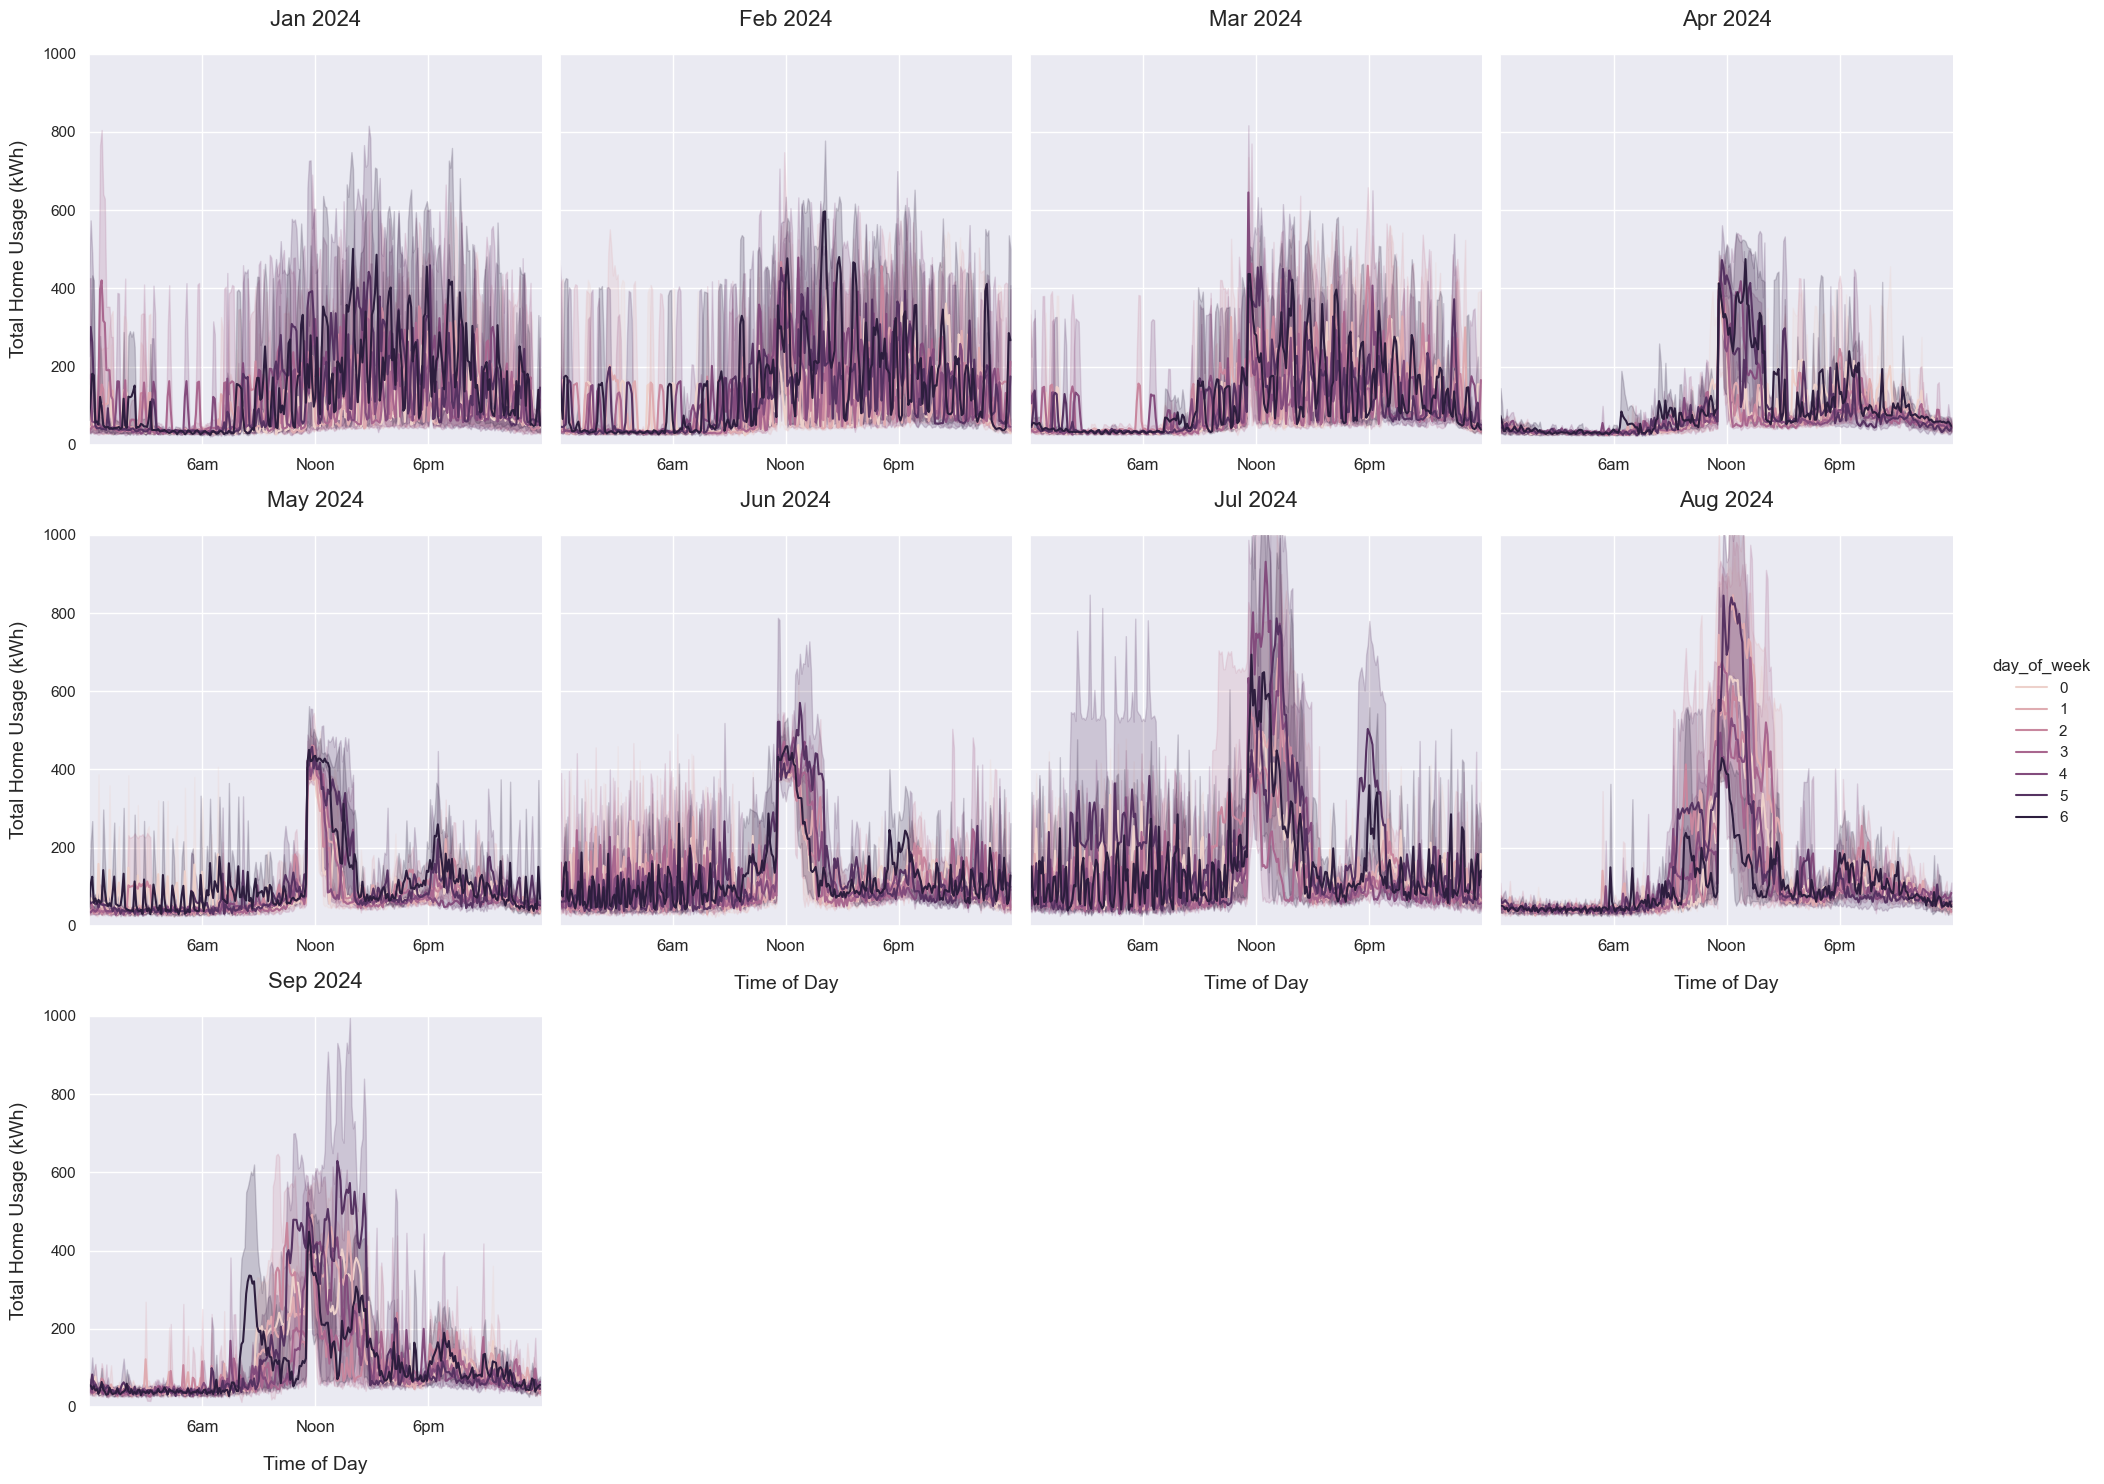

In [260]:
# plot_consumption(data, 2023)
# g22 = plot_consumption(data[data["year"] == 2022], 2022)
# g23 = plot_consumption(data[data["year"] == 2023], 2023)
g24 = plot_consumption(data[data["year"] == 2024], 2024)

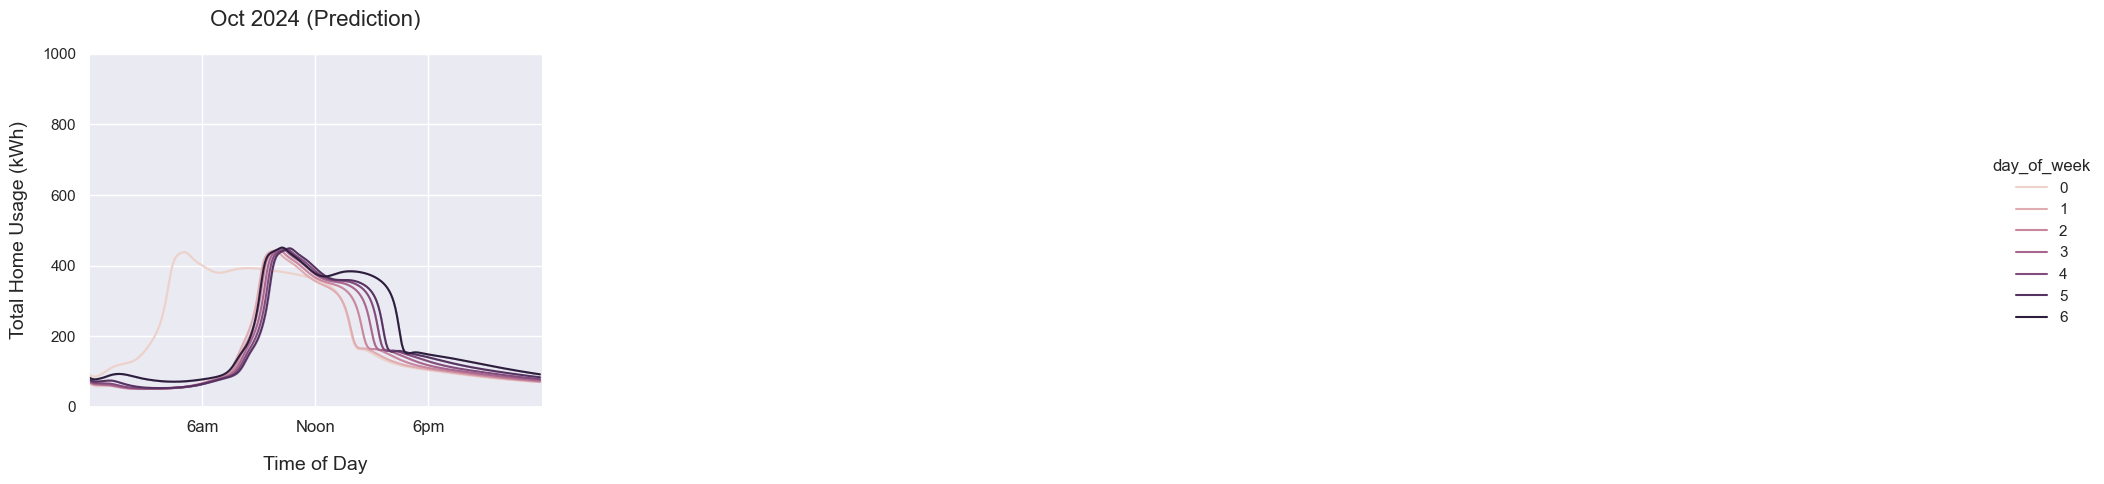

In [261]:
g_new_data = plot_consumption(new_data, 2024, "Prediction")

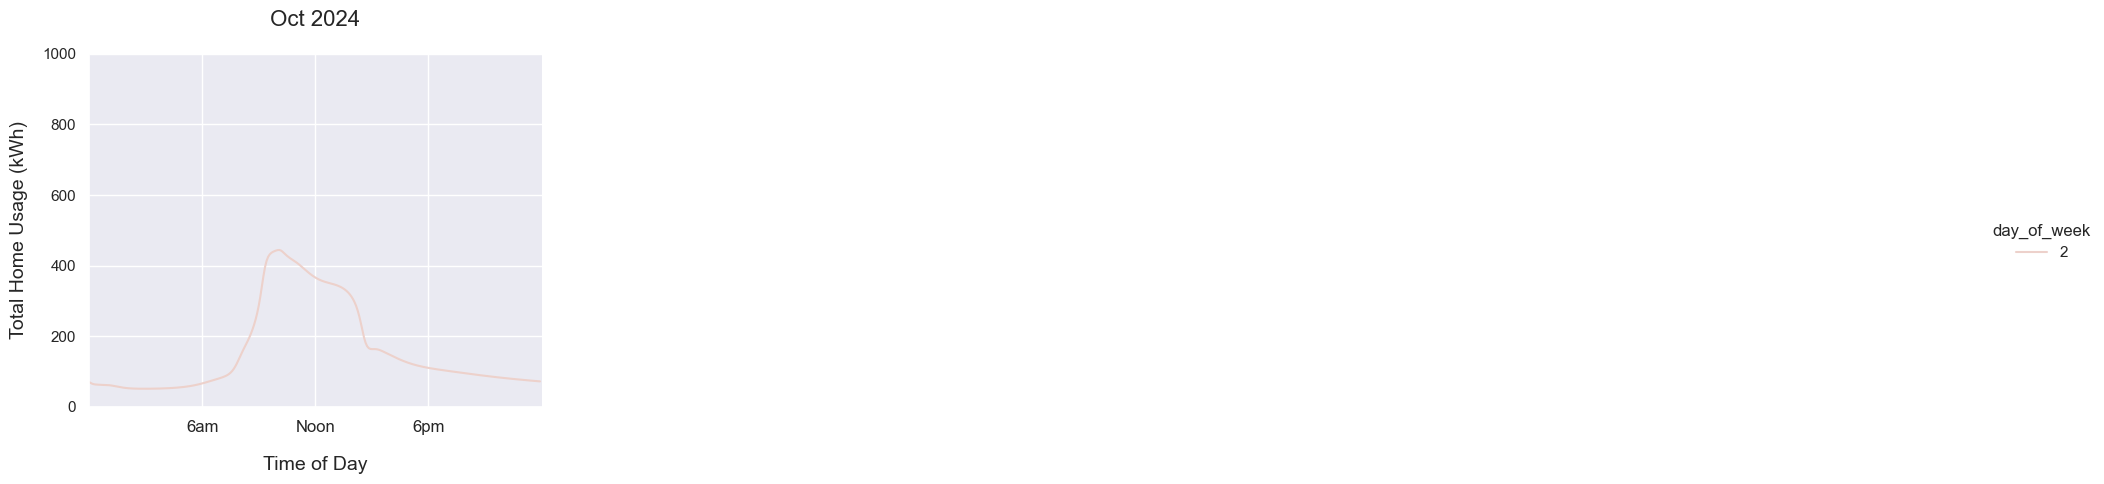

In [268]:

# # Show the new figure
# plt.show()

# interact(update_g1, day=range(30))


# # Create a new figure with enough subplots to accommodate all subplots
# fig = plt.figure(figsize=(12, 6))  # adjust the figure size as needed

# # Get the number of subplots in each relplot
# n1 = len(g1.axes.flat)
# n2 = len(g2.axes.flat)

# # Add subplots from the first relplot
# for i, ax in enumerate(g1.axes.flat):
#     new_ax = fig.add_subplot(2, 4, i+1)
#     new_ax.update_from(ax)  # transfer all axis properties
#     new_ax.set_xlim(ax.get_xlim())  # transfer x limits
#     new_ax.set_ylim(ax.get_ylim())  # transfer y limits
#     new_ax.set_title(ax.get_title())  # transfer title
#     new_ax.set_xlabel(ax.get_xlabel())  # transfer x label
#     new_ax.set_ylabel(ax.get_ylabel())  # transfer y label

#     new_ax.plot(ax.lines[0].get_xdata(), ax.lines[0].get_ydata())
#     ax.remove()  # remove the original axis

# # Add subplots from the second relplot
# colors = cm.rainbow(np.linspace(0, 1, len(g2.axes.flat)))
# for i, ax in enumerate(g2.axes.flat):
#     new_ax = fig.add_subplot(2, 4, n1+i+1)
#     new_ax.update_from(ax)  # transfer all axis properties
#     new_ax.set_xlim(ax.get_xlim())  # transfer x limits
#     new_ax.set_ylim(ax.get_ylim())  # transfer y limits
#     new_ax.set_title(ax.get_title() + " (Prediction)")
#     new_ax.set_xlabel(ax.get_xlabel())  # transfer x label
#     new_ax.set_ylabel(ax.get_ylabel())  # transfer y label
#     new_ax.plot(ax.lines[0].get_xdata(), ax.lines[0].get_ydata(), color='red')  # use a different color
#     ax.remove()  # remove the original axis

# # Layout so plots do not overlap
# fig.tight_layout()

# # Show the new figure
# plt.show()

# interact(update_g1, day=range(30))


g24 = plot_consumption(new_data[new_data["timestamp"].dt.day == 16], 2024)


